In [1]:
import pandas as pd

In [2]:
df = pd.read_parquet("Production.parquet")
df[:5]

,HourDK,PriceArea,CentralPowerMWh,LocalPowerMWh,CommercialPowerMWh,LocalPowerSelfConMWh,OffshoreWindLt100MW_MWh,OffshoreWindGe100MW_MWh,OnshoreWindLt50kW_MWh,OnshoreWindGe50kW_MWh,HydroPowerMWh,SolarPowerLt10kW_MWh,SolarPowerGe10Lt40kW_MWh,SolarPowerGe40kW_MWh,SolarPowerSelfConMWh,UnknownProdMWh,TOTAL_PRODUCTION
HourUTC,,,,,,,,,,,,,,,,,
2022-10-17 21:00:00,2022-10-17 23:00:00,DK1,214.743515,267.023499,96.276588,31.811880,43.178879,1026.378662,3.275440,1170.667480,1.266786,0.055481,0.001805,0.018000,0.0,1.196449,2855.894464
2022-10-17 21:00:00,2022-10-17 23:00:00,DK2,4.608205,51.391109,261.836334,9.739300,12.980800,535.562622,0.522591,275.369537,0.000000,0.028102,0.004318,0.000020,0.0,8.030817,1160.073755
2022-10-17 20:00:00,2022-10-17 22:00:00,DK1,238.176895,307.908844,96.161560,32.361534,55.761963,1019.800415,4.341393,1290.612549,1.278781,0.065216,0.001747,0.016507,0.0,1.247515,3047.734919
2022-10-17 20:00:00,2022-10-17 22:00:00,DK2,7.976231,56.998924,261.412567,10.049680,12.575300,520.810364,0.421284,270.154602,0.000000,0.034355,0.005499,0.000000,0.0,7.009958,1147.448764
2022-10-17 19:00:00,2022-10-17 21:00:00,DK1,291.887573,330.779205,95.955299,33.107136,61.710239,1009.494080,5.113119,1432.513184,1.290120,0.078877,0.003931,0.021549,0.0,1.237764,3263.192076


In [3]:
df_wind = (
    df
    # .filter(regex="PriceArea|Wind")
    [["PriceArea","OnshoreWindGe50kW_MWh"]]
    # .assign(
    #     WIND_PRODUCTION=lambda df: df.sum(axis='columns')
    # )
    .reset_index()
    .query("PriceArea == 'DK1'")
    .query("HourUTC >= '2017-01-01'")
)

df_wind[:2]

,HourUTC,PriceArea,OnshoreWindGe50kW_MWh
0,2022-10-17 21:00:00,DK1,1170.667480
2,2022-10-17 20:00:00,DK1,1290.612549


In [4]:
# df = (
#     df
#     .groupby(
#         [
#             "PriceArea",
#             pd.Grouper(freq="M"),
#         ],
#         # as_index=False
#     )
#     .agg(
#         PRODUCTION=("TOTAL_PRODUCTION", "sum")
#     )
#     .reset_index()
#     .set_index("HourUTC")
# )
# df

In [5]:
# dk_1 = (
#     df
#     .query("PriceArea == 'DK1'")
#     .reset_index()
# )

# dk_2 = (
#     df
#     .query("PriceArea == 'DK2'")
#     .reset_index()
# )

In [6]:
# dk_2[:5]

In [8]:
df_wind_model = (
    df_wind
    .set_index("HourUTC") 
    .groupby(
        pd.Grouper(freq="D")
    )
    .agg(
        MEAN_PRODUCTION=("OnshoreWindGe50kW_MWh", "sum")
    )
    .rolling(30)
    .mean()
    # .plot(figsize=(30,10))
    .reset_index()
)

In [10]:
df_wind_model

,HourUTC,MEAN_PRODUCTION
0,2017-01-01,NaN
1,2017-01-02,NaN
2,2017-01-03,NaN
3,2017-01-04,NaN
4,2017-01-05,NaN
...,...,...
2111,2022-10-13,24321.027015
2112,2022-10-14,23403.506218
2113,2022-10-15,22261.292066
2114,2022-10-16,23007.554446


In [9]:
from prophet import  Prophet

In [11]:
df_train = (
    df_wind_model.rename(columns={"HourUTC":"ds","MEAN_PRODUCTION":"y"})
)

df_train

,ds,y
0,2017-01-01,NaN
1,2017-01-02,NaN
2,2017-01-03,NaN
3,2017-01-04,NaN
4,2017-01-05,NaN
...,...,...
2111,2022-10-13,24321.027015
2112,2022-10-14,23403.506218
2113,2022-10-15,22261.292066
2114,2022-10-16,23007.554446


In [12]:
m = Prophet()
m.fit(df_train)

20:00:38 - cmdstanpy - INFO - Chain [1] start processing
20:00:38 - cmdstanpy - INFO - Chain [1] done processing


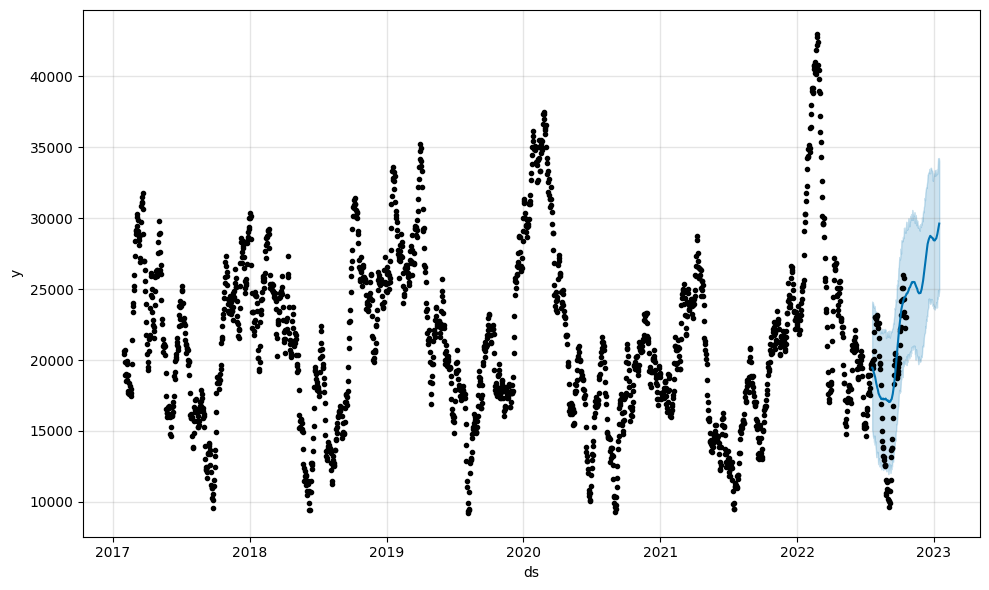

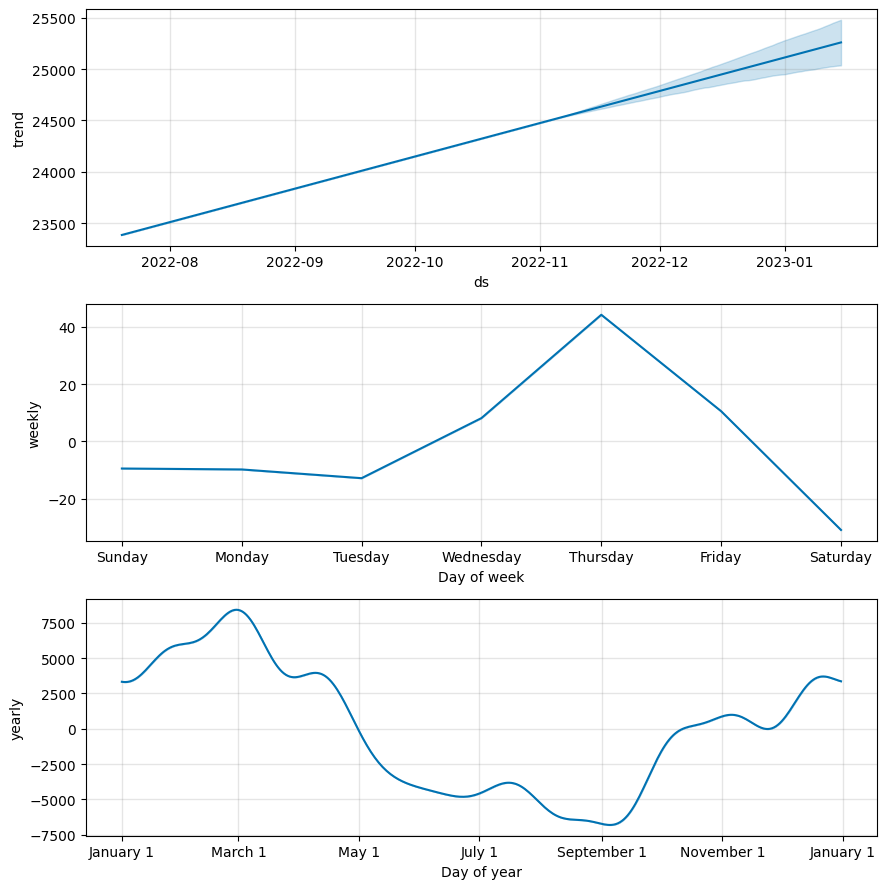

In [14]:
future = m.make_future_dataframe(periods=90)
forecast = m.predict(future)
fig = m.plot(forecast[-180:])
fig = m.plot_components(forecast[-180:])

In [17]:
# Python
from prophet.serialize import model_to_json, model_from_json

with open('serialized_model.json', 'w') as fout:
    fout.write(model_to_json(m))  # Save model

In [18]:
with open('serialized_model.json', 'r') as fin:
    m = model_from_json(fin.read())  # Load model

/Users/tk/miniconda3/envs/ml_energy/lib/python3.9/site-packages/prophet/serialize.py:160: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))
